In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import folium
import panel as pn
from scipy.spatial import cKDTree
from utils import getValues, DATASETS_DIRECTORY_PATH

In [2]:
static = pd.read_csv(f'{DATASETS_DIRECTORY_PATH}static.csv', parse_dates=['timestamp'], low_memory=False)

dynamic = pd.read_csv(f'{DATASETS_DIRECTORY_PATH}dynamic.csv', parse_dates=['timestamp'])
dynamic['geometry'] = gpd.GeoSeries.from_wkt(dynamic['geometry'], crs='EPSG:4326')
dynamic = gpd.GeoDataFrame(dynamic)

gaps = pd.read_csv(f'{DATASETS_DIRECTORY_PATH}gaps.csv', parse_dates=['disappeartime', 'reappeartime'])
gaps['geometry'] = gpd.GeoSeries.from_wkt(gaps['geometry'], crs='EPSG:4326')
gaps = gpd.GeoDataFrame(gaps, geometry=gaps.geometry, crs='EPSG:4326')
gaps['disappearlocation'] = gpd.GeoSeries.from_wkt(gaps['disappearlocation'], crs='EPSG:4326')
gaps['reappearlocation'] = gpd.GeoSeries.from_wkt(gaps['reappearlocation'], crs='EPSG:4326')

edges = pd.read_csv(f'{DATASETS_DIRECTORY_PATH}edges.csv')
edges['geometry'] = gpd.GeoSeries.from_wkt(edges['geometry'], crs='EPSG:4326')
edges = gpd.GeoDataFrame(edges, geometry=edges.geometry, crs='EPSG:4326')

In [3]:
countries = gpd.read_file(f'{DATASETS_DIRECTORY_PATH}ref-countries-2020-01m.geojson/CNTR_RG_01M_2020_4326.geojson')

C:\Users\baudo\AppData\Local\Temp\ipykernel_26176\3668873657.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([dec2deg(coord, 'x') for coord in ax.get_xticks()])
C:\Users\baudo\AppData\Local\Temp\ipykernel_26176\3668873657.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([dec2deg(coord, 'y') for coord in ax.get_yticks()])


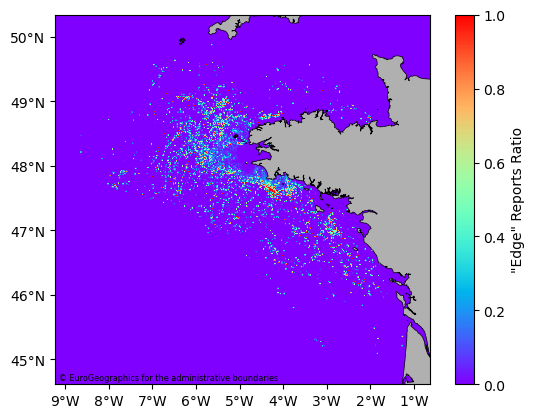

In [4]:
west, south, east, north = dynamic.total_bounds
padding = 0.08
west -= (east - west)*padding
east += (east - west)*padding
south -= (north - south)*padding
north += (north - south)*padding
UK = countries[countries.id=='UK']
FR = countries[countries.id=='FR']
fig, ax = plt.subplots()
cr = '\u00A9 EuroGeographics for the administrative boundaries'
ax.text(0.01, 0.01, cr, transform=ax.transAxes, size='xx-small')
FR.plot(ax=ax, zorder=2, color='#b0b0b0')
UK.plot(ax=ax, zorder=2, color='#b0b0b0')
FR.boundary.plot(ax=ax, zorder=3, lw=0.5, aa=True, color='0')
UK.boundary.plot(ax=ax, zorder=3, lw=0.5, aa=True, color='0')

bins = 500
xedges = np.linspace(west, east, bins + 1)
yedges = np.linspace(south, north, bins + 1)
X1, Y1 = dynamic.geometry.x, dynamic.geometry.y
X2, Y2 = edges.geometry.x, edges.geometry.y
heatmap1, xedges, yedges = np.histogram2d(X1, Y1, bins=(xedges, yedges))
heatmap1[heatmap1 == 0] = 1
heatmap2, _, _ = np.histogram2d(X2, Y2, bins=(xedges, yedges))
extent = [xedges[0], xedges[-1], yedges[-1], yedges[0]]

img = ax.imshow((heatmap2 / (heatmap1)).T, extent=extent,
                aspect='equal', cmap='rainbow', vmax=1.0)
cbar = fig.colorbar(img)
cbar.ax.set_ylabel('"Edge" Reports Ratio')
ax.set_xlim(west, east)
ax.set_ylim(south, north)

def dec2deg(coord, axis=None):
    direction = ''
    if axis == 'x':
        if coord > 0:
            direction = 'E'
        elif coord < 0:
            direction = 'W'
    elif axis == 'y':
        if coord > 0:
            direction = 'N'
        elif coord < 0:
            direction = 'S'
    coord = abs(coord)
    degs = np.floor(coord).astype(int)
    return f'{degs}\u00B0{direction}'

ax.set_xticklabels([dec2deg(coord, 'x') for coord in ax.get_xticks()])
ax.set_yticklabels([dec2deg(coord, 'y') for coord in ax.get_yticks()])

yxratio = 1/np.cos(np.deg2rad((south+north)/2.))
ax.set_aspect(yxratio)

(49.919033, 45.00429)

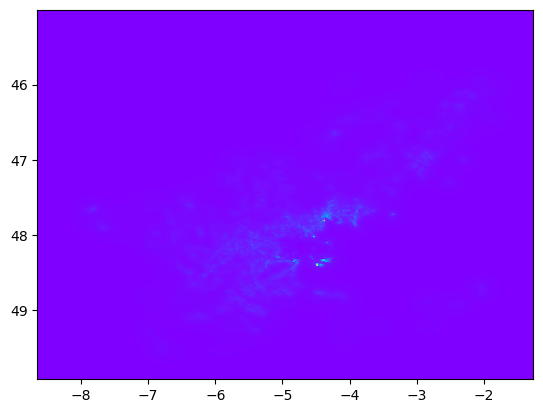

In [5]:
X1 = dynamic.geometry.x
Y1 = dynamic.geometry.y
X2 = edges.geometry.x
Y2 = edges.geometry.y

fig, ax = plt.subplots()
extent = [np.min(X1), np.max(X1), np.max(Y1), np.min(Y1)]
resolution = 300
neighbours = 16

def heatmap(X, Y, resolution, neighbours):
    def data_coord2view_coord(p, resolution):
        dp = np.max(p) - np.min(p)
        dv = (p - np.min(p)) / dp * resolution
        return dv
    xv = data_coord2view_coord(X, resolution)
    yv = data_coord2view_coord(Y, resolution)
    tree = cKDTree(np.array([xv, yv]).T)
    grid = np.mgrid[0:resolution, 0:resolution].T.reshape(resolution**2, 2)
    dists = tree.query(grid, neighbours)
    inv_sum_dists = 1. / dists[0].sum(1)
    im = inv_sum_dists.reshape(resolution, resolution)
    return im

im1 = heatmap(X1, Y1, resolution, neighbours)
im2 = heatmap(X2, Y2, resolution, neighbours)

ax.imshow(im2/(im1 + 1), aspect='auto', extent=extent,
           cmap='rainbow')
ax.set_xlim(extent[0], extent[1])
ax.set_ylim(extent[2], extent[3])

Row
    [0] WidgetBox
        [0] IntInput(end=16603, name='Gap ID', start=0)
        [1] EditableIntSlider(end=1000, fixed_end=1000, fixed_start=0, name='Previous Positions', value=200, width=300)
        [2] EditableIntSlider(end=1000, fixed_end=1000, fixed_start=0, name='Next Positions', value=200, width=300)
        [3] ParamFunction(function, _pane=Markdown, defer_load=False)
    [1] ParamFunction(function, _pane=Folium, defer_load=False)
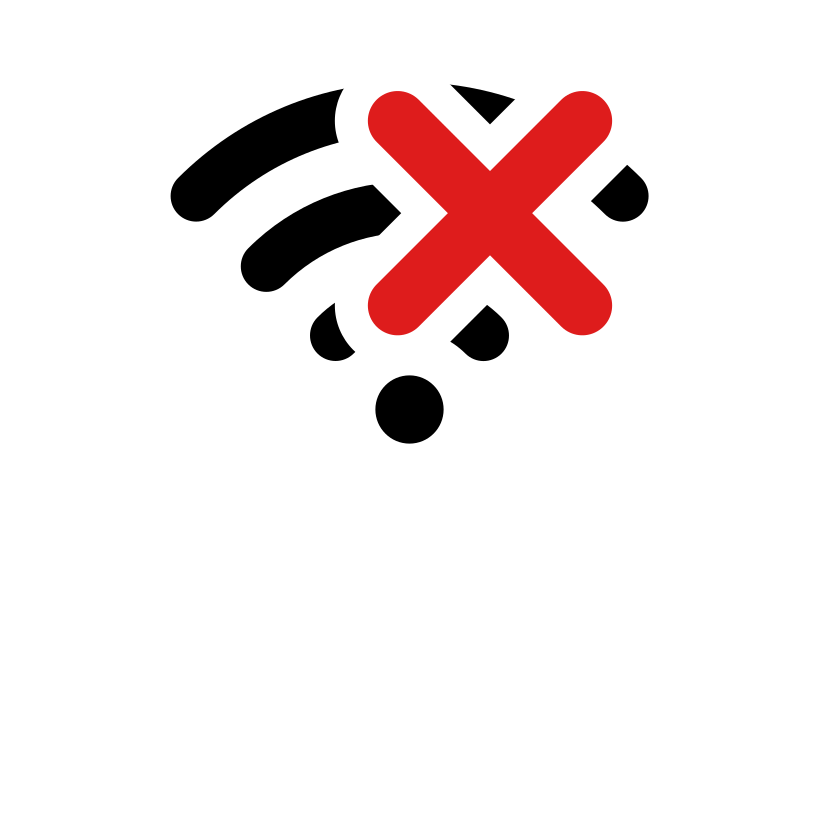
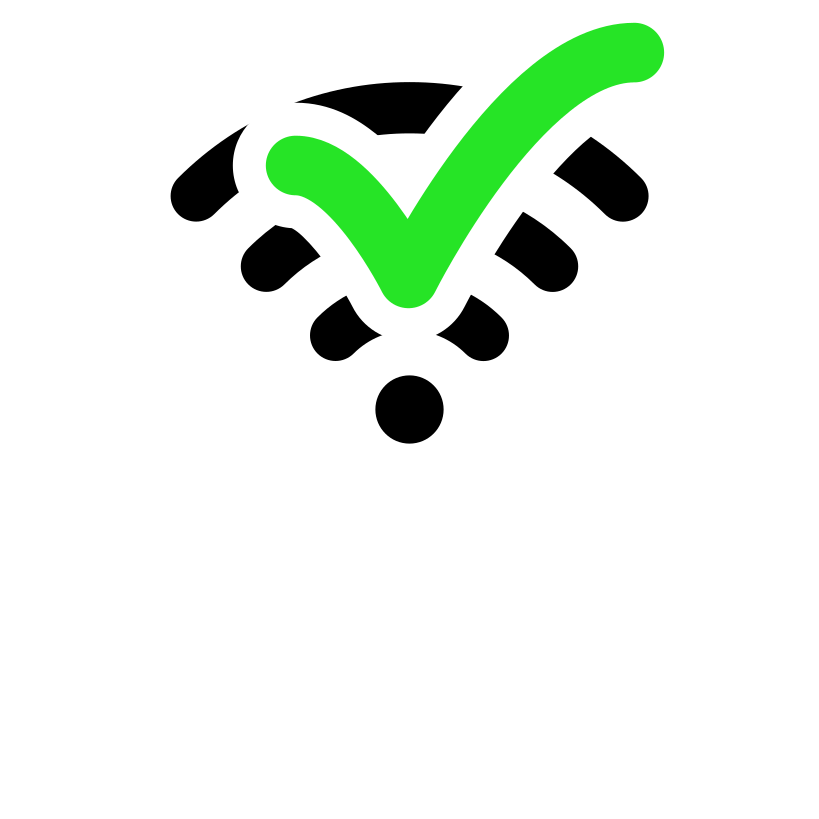

In [6]:
pn.extension()

idSelector = pn.widgets.IntInput(name='Gap ID', value=0, step=1, start=0, end=len(gaps)-1)
previousSlider = pn.widgets.EditableIntSlider(name='Previous Positions', fixed_start=0, fixed_end=1000, value=200)
nextSlider = pn.widgets.EditableIntSlider(name='Next Positions', fixed_start=0, fixed_end=1000, value=200)

disappearIcon = folium.features.CustomIcon(icon_image='Markers/x.png', icon_size=(40,40), icon_anchor=(20,20))
reappearIcon = folium.features.CustomIcon(icon_image='Markers/v.png', icon_size=(40,40), icon_anchor=(20,20))

def plot(data):
    mapFeatures = []
    
    lineKwargs = {'color': 'black', 'opacity': 0.3, 'weight': 3}
    def normalLine(line):
        return folium.PolyLine([(point.y, point.x) for point in line], **lineKwargs)
    def gapLine(line):
        return folium.PolyLine([(point.y, point.x) for point in line], dash_array='8', **lineKwargs)
    def normalMarker(report):
        return folium.CircleMarker(location=(report.geometry.y, report.geometry.x), radius=2, stroke=False,
                                   fill_color='black', fill_opacity=1.0)
    popup = lambda report: report.timestamp.strftime('%d/%m/%Y\n%H:%M:%S')
    markerKwargs = lambda report: {'location': (report.geometry.y, report.geometry.x), 'popup': popup(report)}
    def disappearMarker(report): 
        return folium.Marker(icon=disappearIcon, **markerKwargs(report))
    def reappearMarker(report):
        return folium.Marker(icon=reappearIcon, **markerKwargs(report))
    
    currentLine = []
    for report in data['dynamic'].itertuples(index=False):
        if report.edge == 'none':
            currentLine.append(report.geometry)
            mapFeatures.append(normalMarker(report))
        elif report.edge == 'disappear':
            currentLine.append(report.geometry)
            mapFeatures.append(normalLine(currentLine))
            currentLine = []
            currentLine.append(report.geometry)
            if report.timestamp == data['gap'].disappeartime:
                mapFeatures.append(disappearMarker(report))
            else:
                mapFeatures.append(normalMarker(report))
        elif report.edge == 'lone':
            currentLine.append(report.geometry)
            if report.timestamp == data['gap'].disappeartime:
                mapFeatures.append(disappearMarker(report))
            elif report.timestamp == data['gap'].reappeartime:
                mapFeatures.append(reappearMarker(report))
            else:
                mapFeatures.append(normalMarker(report))
        else:
            currentLine.append(report.geometry)
            mapFeatures.append(gapLine(currentLine))
            currentLine = []
            currentLine.append(report.geometry)
            mapFeatures.append(normalMarker(report))
            if report.timestamp == data['gap'].reappeartime:
                mapFeatures.append(reappearMarker(report))
            else:
                mapFeatures.append(normalMarker(report))
    if data['dynamic'].iloc[-1].edge in ['none', 'disappear']:
        mapFeatures.append(normalLine(currentLine))
    else:
        mapFeatures.append(gapLine(currentLine))
    
    return mapFeatures

def visualise(gap_id, previousSlider, nextSlider):
    #NB: both "previousSlider" and "nextSlider" values are unused but trigger map updates
    data = iData()
    m = folium.Map(tiles="cartodb positron", location=(48, -5), zoom_start=7, control_scale=True, prefer_canvas=True)
    for mapFeature in plot(data):
        mapFeature.add_to(m)
    return m
iMap = pn.bind(visualise, idSelector, previousSlider, nextSlider)

def getData(gap_id, previousReports, nextReports):
    data = {}
    previousReports += 1
    nextReports += 1
    data['mmsi'] = gaps.loc[gap_id].mmsi
    data['gap'] = gaps.loc[gap_id]
    data['static'] = static.loc[static.sourcemmsi == data['mmsi']]
    reports = dynamic.loc[dynamic.sourcemmsi == data['mmsi']]
    prev = reports.loc[reports.timestamp <= data['gap'].disappeartime].iloc[-previousReports:]
    nex = reports.loc[reports.timestamp >= data['gap'].reappeartime].iloc[:nextReports]
    data['dynamic'] = pd.concat([prev, nex])
    return data
iData = pn.bind(getData, idSelector, previousSlider, nextSlider)

def getInfos(gap_id):
    
    def toMarkdown(infos):
        md = ''
        for info in infos:
            md += f'**{info}:** {infos[info]}\n\n'
        return md.rstrip('\n')
    
    data = iData()
    infos = {}
    infos['Vessel Name'] = list(getValues(data['static'].shipname).keys())[0]
    infos['MMSI'] = data['mmsi']
    md = '---\n' + toMarkdown(infos)
    
    def getDest():
        staticReport = data['static'].loc[data['static'].timestamp <= data['gap'].disappeartime].iloc[-1]
        dest = staticReport.destination
        if dest.strip() != '':
            age = data['gap'].disappeartime - staticReport.timestamp
            dest += f'({age})'
            return dest
        else:
            return 'unknown'
    
    infos = {}
    infos['Declared Destination'] = getDest()
    infos['Gap Duration'] = pd.to_timedelta(data['gap'].darkduration, unit='S')
    infos['Gap Distance'] = str(np.round(data['gap'].darkdistance, 1)) + ' NM'
    infos['Minimum Average Speed'] = str(np.round(data['gap'].darkspeed, 2)) + ' kts'
    md += '\n\n---\n' + toMarkdown(infos)
    return pn.pane.Markdown(md)

infos = pn.bind(getInfos, idSelector)

controls = pn.WidgetBox(idSelector, previousSlider, nextSlider, infos)

iPane = pn.bind(lambda iMap: pn.pane.plot.Folium(iMap, height=400), iMap)
pn.Row(controls, iPane)

In [7]:
from jinja2 import Template
import requests

folium.folium.Map._template = Template(
"""
{% macro header(this, kwargs) %}
    <meta name="viewport" content="width=device-width,
        initial-scale=1.0, maximum-scale=1.0, user-scalable=no" />
    <style>
        #{{ this.get_name() }} {
            position: {{this.position}};
            width: {{this.width[0]}}{{this.width[1]}};
            height: {{this.height[0]}}{{this.height[1]}};
            left: {{this.left[0]}}{{this.left[1]}};
            top: {{this.top[0]}}{{this.top[1]}};
        }
        .leaflet-container { font-size: 1rem; }
    </style>
{% endmacro %}
{% macro html(this, kwargs) %}
    <div class="folium-map" id={{ this.get_name()|tojson }} ></div>
{% endmacro %}
{% macro script(this, kwargs) %}
    var {{ this.get_name() }} = L.map(
        {{ this.get_name()|tojson }},
        {
            center: {{ this.location|tojson }},
            crs: L.CRS.{{ this.crs }},
            {%- for key, value in this.options.items() %}
            {{ key }}: {{ value|tojson }},
            {%- endfor %}
        }
    );
    //---------------beginning of the modified template---------------
    {{ this.get_name() }}.on(
    'zoomend', function(){
        var zoom = {{ this.get_name() }}.getZoom();
        document.cookie = ['zoom=', JSON.stringify(zoom),
                           '; path=/notebooks/Desktop/PFE/Scripts/Analysis.ipynb;'].join('');
    }
    );
    {{ this.get_name() }}.on(
    'moveend', function(){
        var center = {{ this.get_name() }}.getCenter();
        document.cookie = ['center=', JSON.stringify(center)].join('');
    }
    );
    //------------------end of the modified template------------------
    {%- if this.control_scale %}
    L.control.scale().addTo({{ this.get_name() }});
    {%- endif %}
    {% if this.objects_to_stay_in_front %}
    function objects_in_front() {
        {%- for obj in this.objects_to_stay_in_front %}
            {{ obj.get_name() }}.bringToFront();
        {%- endfor %}
    };
    {{ this.get_name() }}.on("overlayadd", objects_in_front);
    $(document).ready(objects_in_front);
    {%- endif %}
{% endmacro %}
"""
)

m = folium.Map(tiles="cartodb positron", location=(48, -5), zoom_start=7)
m